# networkm

> Network Models based on `networkx` MultiDiGraph objects endowed with dynamics. `Graph Functions` contains various manipulation tools for graph objects. `Model Functions` contains methods of simulating these graphs as coupled, time-delayed differential equations with noise, with current support for Boolean functions / Boolean networks. `Network Class` contains the culmination of these functions in a single `BooleanNetwork` class object for pipelined analysis. `PUF Functions` analyzes these networks in the context of physically unclonable functions. Accelerated with `numba`. 

## Install

`pip install networkm`

## How to use

In [ ]:
import networkm
from networkm import *

This package models Boolean Networks with dynamics of the form

$\tau_{i}\frac{dx_{i}}{dt}=-x_{i}(t)+f_{i}[pred_{i}(t-delays)]+noise$

where tau is a time-constant, f is a logical function, $pred_{i}$ are the nodes flowing into node $x_{i}$ after some time-delay along each edge, and the noise term is random.

We can quickly simulate entire distributions of complex networks and analyze their statistics:

query : Elapsed time: 7.9315 seconds


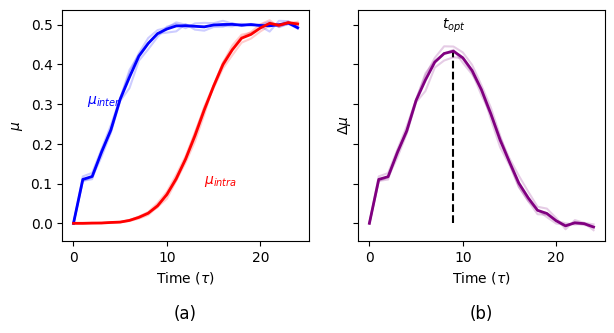

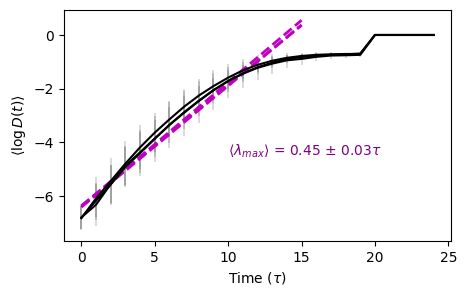

In [ ]:
bne=BooleanNetworkEnsemble(classes=3,instances=3,challenges=3,repeats=3,
                           g = (nx.random_regular_graph,3,256),f=XOR,tau=(rng.normal,1,0.1),a=np.inf,
                           edge_replacements=dict(a=np.inf,tau=(rng.normal,0.5,0.05),
                                                  f=MPX,delay=(rng.random,0,0.5)),
                           delay=(rng.random,0,1),dt=0.01,T=25,noise=0.01,hold=(rng.normal,1,0.1),
                           decimation=None)
plot_mu(bne.data)
plot_lya(bne.data)

In [ ]:
bne[0].plot_graph()

Or start more simply, and consider a Ring Oscillator / Repressilator: https://en.wikipedia.org/wiki/Ring_oscillator , https://en.wikipedia.org/wiki/Repressilator. Real-world implications in e.g circuit design and gene-regulatory networks.

The system is a ring of 3 nodes which connect to their left neighbor and cyclically invert eachother.

In [ ]:
g=ring(N=3,left=True,right=False,loop=False)
print_graph(g)

|Node|Predecessors|Successors|
|0   |1           |2         |
|1   |2           |0         |
|2   |0           |1         |



We model this with the simplest case, as follows. We give each node the NOT function. This function is executed differentially with a time-constant of 1. The node receives its neighbors state instantly; we put no explicit time-delays along edges, and include no noise. We initialize one node to 1, and hold all nodes at their steady-state value from this configuration for the default value of one time-constant. Then they are released and have the following dynamics:

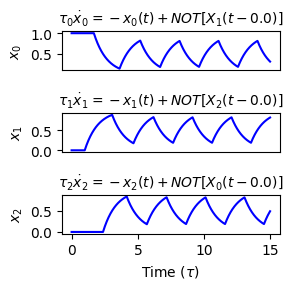

In [ ]:
ro=BooleanNetwork(g=ring(N=3,left=True,right=False,loop=False),
                 f=NOT,
                 tau=1,
                 delay=0,
                 noise=0, 
                 a=np.inf, #this makes the derivative integer-valued; see `sigmoid` function
                 init=[1,0,0],
                 hold=None,
                 edge_replacements=None,
                 T=15,
                 dt=0.01
                )
fig_params(reset=True)
ro.plot_timeseries()

The dynamics are not restricted to the edges of a hypercube, allowing Boolean Networks to explore regions of the analog phase space in ways that traditional models forcing only binary valued states don't capture:

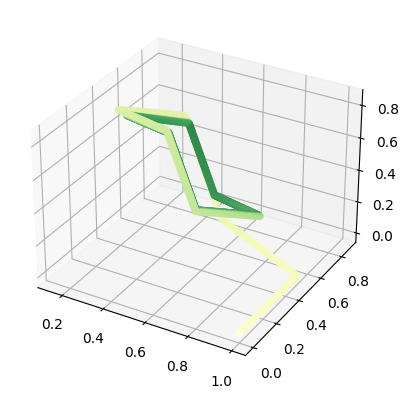

In [ ]:
ro.plot_3d()

For a more complex example we consider a "Hybrid Boolean Network" composed of a multiplexer - which forces inital conditions using a clock - connected to a chaotic ring network, which executes the XOR function. This has real-world implications in e.g cryptography and physically unclonable functions (PUF) as an HBN-PUF - see https://ieeexplore.ieee.org/document/9380284.

More explicitly, we consider a 16-node ring where each node executes the 3-input XOR function on itself and its two neighbors. We include noise, time-delays, different rise/fall times for tau, and replace each node with itself + a multiplexer that sets the initial condition and copies the state thereafter, with its own set of dynamical constants.

In [ ]:
b=BooleanNetwork(g = nx.random_regular_graph(3,16),
          a = (rng.normal,15,5),
          tau = (rng.normal,[0.5,0.4],[0.1,0.05]),
          f = XOR,
          delay = (rng.random,0,1),
          edge_replacements = dict(
              delay = (rng.normal,0.5,0.1),
              a = (rng.normal,15,5),
              tau = (rng.normal,[0.2,0.15],[0.05,0.05]),
              f = MPX            
          ),
          T = 15,
          dt = 0.01,
          noise = 0.01,
          init = None,
          hold = None,
          plot=False,
         )

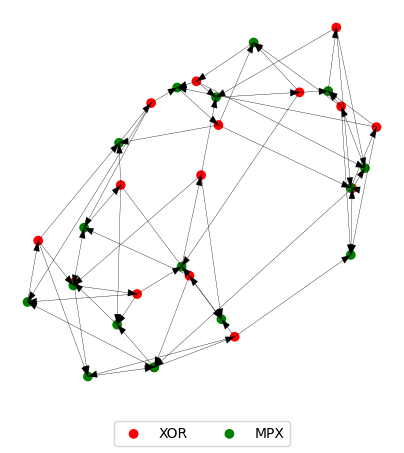

In [ ]:
b.plot_graph()

We can quickly analyze differences between e.g randomly shuffled attributes and noise:

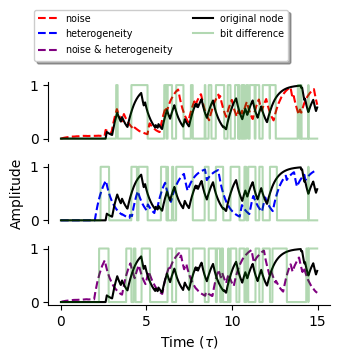

In [ ]:
chal=b.random_init()
x,x0,y,y0=b.integrate(init=chal,noise=0.),\
          b.integrate(init=chal,noise=0.1),\
          b.query(instances=1,challenges=[chal],repeats=1,noise=0)[0,0,0],\
          b.integrate(noise=0.1) #parameters been shuffled by query
plot_comparison(x,x0,y,y0,i=0)

In [ ]:
sidis.refresh()